## Análisis de precios por zona

La idea de esta seccion es estudiar la influencia de la zona, ya sea Provincia o Barrio en los valores de las propiedades. Para esto vamos a analizar tanto el precio en dolares por m2 como el precio en dolares, lo que nos permitirá concluir cual de estas variables es la que tiene mayor valor predictivo.

In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import unidecode

In [5]:
df = pd.read_csv("../data/properatti_minusculas.csv", encoding="UTF-8")

In [3]:
df.shape

(121220, 27)

In [6]:
# Queremos ver cuantas propiedades hay en cada provincia
df['state_name'].value_counts()

capital federal                 32316
bs.as. g.b.a. zona norte        25560
bs.as. g.b.a. zona sur          13952
cordoba                         12069
santa fe                        10172
buenos aires costa atlantica    10006
bs.as. g.b.a. zona oeste         9322
buenos aires interior            2291
rio negro                         808
neuquen                           733
mendoza                           681
tucuman                           674
corrientes                        583
misiones                          464
entre rios                        369
salta                             278
chubut                            259
san luis                          252
la pampa                          157
formosa                            65
chaco                              57
san juan                           40
tierra del fuego                   31
catamarca                          27
jujuy                              26
santa cruz                         20
la rioja    

In [7]:
# Queremos ver si hay nulos en state_name
df['state_name'].isnull().sum() 

0

In [8]:
# Queremos ver cuantas propiedades hay en cada Barrio
df['place_name'].value_counts()

cordoba                               9254
rosario                               8504
mar del plata                         6534
tigre                                 3324
nordelta                              3315
belgrano                              2992
palermo                               2885
la plata                              2534
caballito                             2273
pilar                                 2228
villa urquiza                         1632
olivos                                1590
recoleta                              1547
lomas de zamora                       1529
flores                                1354
ituzaingo                             1340
villa crespo                          1331
capital federal                       1297
san telmo                             1216
moron                                 1209
almagro                               1165
barrio norte                          1140
ramos mejia                           1127
martinez   

In [9]:
# Queremos ver si hay nulos en place_name
df['place_name'].isnull().sum() 

23

In [10]:
#Descubrimos que los nulos de place_name son de Tigre. Los reemplazamos
df['place_name'].fillna('Tigre', inplace = True)  

In [11]:
# Queremos ver si hay nulos en price_usd_per_m2
df['price_usd_per_m2'].isnull().sum()

52603

In [12]:
# Queremos ver si hay nulos en price_aprox_usd
df['price_aprox_usd'].isnull().sum()

20410

# Limpieza de nulos

### Respecto a los valores nulos de precios tenemos tres opciones: 
1) Completarlos con los valores de la media de cada zona. El problema de esta metodologia es que estariamos afectando al futuro modelo predictivo
2) Descartarlos. Estos valores nulos representan el 16% de nuestra base de datos, si bien es un numero importante puede ser una opcion valida.
3) Recuperar informacion con Regex. Esta es la mejor opcion y puede diminuir considerablemente el numero de valores a descartar/

# Limpieza de outliers

## Por precio por m2

### Se analizará el precio en dolares por m2 en primer lugar ya que es una practica usual del mercado inmobiliario establecer valores de precio por m2 por zonas.

Se eliminarán outliers a nivel provincia (state_name) salvo en Capital Federal que lo vamos a hacer por barrios (place_name)

In [13]:
#Seleccionamos todas las provincias menos Capital Federal
df1 = df.loc[(df['state_name'] != 'capital federal')]
df1['state_name'].unique()

array(['bs.as. g.b.a. zona sur', 'buenos aires costa atlantica',
       'entre rios', 'bs.as. g.b.a. zona norte', 'santa fe', 'cordoba',
       'bs.as. g.b.a. zona oeste', 'misiones', 'buenos aires interior',
       'salta', 'neuquen', 'rio negro', 'san luis', 'mendoza',
       'corrientes', 'chubut', 'tucuman', 'la pampa', 'chaco', 'san juan',
       'santa cruz', 'tierra del fuego', 'catamarca',
       'santiago del estero', 'jujuy', 'la rioja', 'formosa'],
      dtype=object)

In [15]:
# Calculamos la media de cada provincia 
df_media_state = df1.groupby('state_name')['price_usd_per_m2'].mean()
df_media_state

state_name
bs.as. g.b.a. zona norte        1860.779924
bs.as. g.b.a. zona oeste        1349.904779
bs.as. g.b.a. zona sur          1525.356899
buenos aires costa atlantica    1574.633123
buenos aires interior            959.950891
catamarca                        556.045469
chaco                            939.802732
chubut                          1708.614091
cordoba                         1219.628477
corrientes                      1492.307008
entre rios                      1255.605614
formosa                         1509.648462
jujuy                            617.077447
la pampa                         899.381177
la rioja                         243.029233
mendoza                         1689.744992
misiones                         753.052748
neuquen                         1788.103357
rio negro                       1925.470230
salta                           2547.463501
san juan                        1648.244241
san luis                        1600.125287
santa cruz           

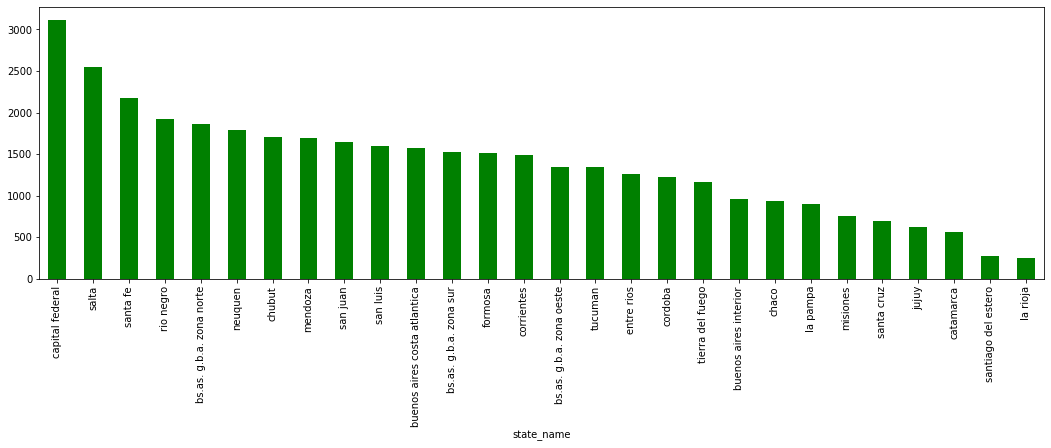

In [16]:
# Graficamos las medias de precios por m2 por Provincia
plot_state_m2 = df.groupby('state_name').describe()
plot_state_m2[('price_usd_per_m2', 'mean')].sort_values(ascending=False).plot.bar(figsize=(18,5), facecolor='g')

In [17]:
# Calculamos el desvio standar de cada provincia
df_std_state = df1.groupby('state_name')['price_usd_per_m2'].std()
df_std_state

state_name
bs.as. g.b.a. zona norte        1894.265775
bs.as. g.b.a. zona oeste        1636.372787
bs.as. g.b.a. zona sur          1119.507894
buenos aires costa atlantica     916.209264
buenos aires interior            707.412120
catamarca                        562.821671
chaco                            574.032766
chubut                          1498.756329
cordoba                          859.615119
corrientes                       614.172324
entre rios                      2639.518871
formosa                            8.883072
jujuy                            711.251908
la pampa                         335.627014
la rioja                                NaN
mendoza                         2615.406046
misiones                         653.528073
neuquen                         1406.050357
rio negro                       1556.647257
salta                           4953.591438
san juan                        2182.478180
san luis                        3442.022704
santa cruz           

In [18]:
# Definimos una funcion que establece el valor de los outliers
def outlier_value_sup(X):
    value = np.nanmean(X)+(np.nanstd(X)*2)
    return value

### Valores de outliers

In [19]:
# Se determinan los valores de los outliers por Provincia utilizando la funcion anterior con pivot table
# Utilizamos como indice state_name
state_m2_pivot = df.pivot_table(values='price_usd_per_m2',index='state_name',aggfunc= outlier_value_sup)
state_m2_pivot

,price_usd_per_m2
state_name,
bs.as. g.b.a. zona norte,5649.202639
bs.as. g.b.a. zona oeste,4622.296369
bs.as. g.b.a. zona sur,3764.191323
buenos aires costa atlantica,3406.907361
buenos aires interior,2374.075244
capital federal,10478.833535
catamarca,1583.612553
chaco,2067.180705
chubut,4694.112623


De esta forma obtuvimos los puntos de corte que definiran a los valores por encima de estos como outliers

In [20]:
# Reseteamos los indices y state_name vuelve a ser una columna
state_m2_pivot_new=state_m2_pivot.reset_index()
state_m2_pivot_new

,state_name,price_usd_per_m2
0,bs.as. g.b.a. zona norte,5649.202639
1,bs.as. g.b.a. zona oeste,4622.296369
2,bs.as. g.b.a. zona sur,3764.191323
3,buenos aires costa atlantica,3406.907361
4,buenos aires interior,2374.075244
5,capital federal,10478.833535
6,catamarca,1583.612553
7,chaco,2067.180705
8,chubut,4694.112623
9,cordoba,2938.624726


In [21]:
# Utilizamos los puntos de corte calculados por state_name y lo utilizamos para buscar en el df original 
# aquellos valores de ese state_name que estén por arriba de ese valor
state_m2_index=df[(df['state_name']==state_m2_pivot_new.loc[0,'state_name']) &
                    (df['price_usd_per_m2']>state_m2_pivot_new.loc[0,'price_usd_per_m2'])].index.values
df.loc[state_m2_index]

,Unnamed: 0,Unnamed: 0.1,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
571,571,571,sell,apartment,nordelta,|argentina|bs.as. g.b.a. zona norte|tigre|nord...,Argentina,bs.as. g.b.a. zona norte,NaN,"-34.4046410947,-58.6487591562",...,147.0,5782.312925,5782.312925,NaN,4.0,NaN,http://www.properati.com.ar/15fcd_venta_depart...,"yoo nordelta es un proyecto de carlos ott, con...",condominio yoo nordelta - nordelta - tigre,https://thumbs4.properati.com/1/BXXKVYTLw03Jds...
610,610,610,sell,apartment,la lucila,|argentina|bs.as. g.b.a. zona norte|vicente lo...,Argentina,bs.as. g.b.a. zona norte,3432310.0,"-34.4941179,-58.4844125",...,100.0,8130.000000,8130.000000,NaN,5.0,NaN,http://www.properati.com.ar/15fer_venta_depart...,excelente unidad de 5 ambientes grande de 225 ...,"exclusivo 5 ambientes 100mt2 ,sobre libertado...",https://thumbs4.properati.com/3/hBCs9adSV577xO...
628,628,628,sell,apartment,olivos,|argentina|bs.as. g.b.a. zona norte|vicente lo...,Argentina,bs.as. g.b.a. zona norte,3430310.0,"-34.5082181,-58.4794478",...,44.0,5681.818182,5681.818182,NaN,1.0,NaN,http://www.properati.com.ar/15ffo_venta_depart...,departamento tipo loft en piso 15 de 54 mts to...,inmejorable departamento en olivos la palmera,https://thumbs4.properati.com/4/uTdCLiQla6thgE...
6429,6429,6429,sell,apartment,vicente lopez,|argentina|bs.as. g.b.a. zona norte|vicente lo...,Argentina,bs.as. g.b.a. zona norte,NaN,"-34.5317584,-58.4653014",...,77.0,7222.222222,8441.558442,NaN,2.0,85.0,http://www.properati.com.ar/15u0c_venta_depart...,excelente dos ambientes con vista abierta al r...,departamento en venta,https://thumbs4.properati.com/1/SPs2_UtvjchTUn...
9437,9437,9437,sell,house,vicente lopez,|argentina|bs.as. g.b.a. zona norte|vicente lo...,Argentina,bs.as. g.b.a. zona norte,3427504.0,NaN,...,NaN,7368.421053,NaN,NaN,NaN,NaN,http://www.properati.com.ar/1645u_venta_casa_v...,lote en excelente zona de vicente lopez. predo...,"casa 475m2 en san martin, av. del libertador g...",https://thumbs4.properati.com/8/ORfvXTkzkD40he...
10756,10756,10756,sell,house,nordelta,|argentina|bs.as. g.b.a. zona norte|tigre|nord...,Argentina,bs.as. g.b.a. zona norte,NaN,NaN,...,55.0,17307.692308,4090.909091,NaN,NaN,NaN,http://www.properati.com.ar/168yb_venta_casa_n...,lindisimo dpto. de 2 ambientes en venta con re...,"casa 13m2 con cochera, tigre, nordelta, por u$...",https://thumbs4.properati.com/7/Br32nM65HeuTXa...
20250,20250,20250,sell,house,tigre,|argentina|bs.as. g.b.a. zona norte|tigre|,Argentina,bs.as. g.b.a. zona norte,3427753.0,NaN,...,120.0,9900.000000,1650.000000,NaN,NaN,NaN,http://www.properati.com.ar/17c3k_venta_casa_t...,muy lindo triplex a estrenar de en el complejo...,"casa 20m2 con cochera en lopez, vicente 400, b...",https://thumbs4.properati.com/6/PKoA4oezYVN9I4...
20423,20423,20423,sell,apartment,victoria,|argentina|bs.as. g.b.a. zona norte|san fernan...,Argentina,bs.as. g.b.a. zona norte,3427500.0,NaN,...,72.0,12608.695652,4027.777778,NaN,NaN,NaN,http://www.properati.com.ar/17cm7_venta_depart...,"hall, living/comedor con salida a balca3n terr...","departamento 23m2 con cochera, san fernando, v...",https://thumbs4.properati.com/1/m-jIXiBTaHTKh5...
20424,20424,20424,sell,apartment,victoria,|argentina|bs.as. g.b.a. zona norte|san fernan...,Argentina,bs.as. g.b.a. zona norte,3427500.0,NaN,...,72.0,11346.153846,4097.222222,NaN,NaN,NaN,http://www.properati.com.ar/17cm8_venta_depart...,"impecable! hall, living/comedor con salida a b...","departamento 26m2 con plantas, san fernando, v...",https://thumbs4.properati.com/9/7zYj4ASjlzKQE0...
22429,22429,22429,sell,apartment,vicente lopez,|argentina|bs.as. g.b.a. zona norte|vicente lo...,Argentina,bs.as. g.b.a. zona norte,NaN,"-34.5327315,-58.4685608",...,80.0,7500.000000,7500.000000,NaN,2.0,NaN,http://www.properati.com.ar/17ijy_venta_depart...,"

In [22]:
# Encontramos los outliers
df.loc[state_m2_index, 'price_usd_per_m2']

571        5782.312925
610        8130.000000
628        5681.818182
6429       7222.222222
9437       7368.421053
10756     17307.692308
20250      9900.000000
20423     12608.695652
20424     11346.153846
22429      7500.000000
23694      5937.500000
24925      6800.000000
24926      9875.000000
24944      7714.285714
24992     13461.538462
25080     11333.333333
25081     11333.333333
25138     10428.571429
25170      8750.000000
25217      6177.777778
26989     38478.688525
26992     48296.222222
26993     37053.442623
26994     39776.923077
27000     43655.652174
27001     45640.000000
27004     48296.222222
27059     43655.652174
27060     39776.923077
27061     43655.652174
              ...     
107149     5952.380952
107162     8928.571429
107173    14166.666667
107178     6547.619048
107183    15714.285714
107188    15238.095238
107192    14166.666667
107196    11785.714286
107197    14166.666667
107225    13095.238095
107233    26666.666667
107311     7380.952381
107316     

In [23]:
# Establecemos un nuevo df excuyendo los outliers
df_new = df.drop(state_m2_index)

Se eliminan outliers a nivel Barrios (place_name) unicamente en Capital Federal 

In [24]:
df2 = df.loc[(df['state_name'] == 'capital federal')]
df2['place_name'].value_counts()

belgrano                2992
palermo                 2885
caballito               2273
villa urquiza           1629
recoleta                1547
flores                  1354
villa crespo            1331
capital federal         1297
san telmo               1216
almagro                 1165
barrio norte            1140
boedo                    890
nunez                    778
balvanera                667
puerto madero            647
san cristobal            614
saavedra                 542
monserrat                538
palermo hollywood        532
floresta                 516
villa del parque         488
villa luro               432
barracas                 425
villa devoto             420
mataderos                418
liniers                  408
palermo soho             394
colegiales               352
parque patricios         322
congreso                 304
                        ... 
palermo chico            232
chacarita                227
centro / microcentro     223
boca          

In [25]:
# Queremos sacar los place_names con una frecuencia menor a x casos, ya que no tiene sentido calcular la media y std
df2 = df2.groupby('place_name').filter(lambda x: len(x) > 10)
df2.shape

(32306, 27)

In [26]:
# Calculamos la media de cada Barrio 
df_media_place = df2.groupby('place_name')['price_usd_per_m2'].mean()
df_media_place

place_name
abasto                   2057.529147
agronomia                2088.124134
almagro                  2749.102521
balvanera                1982.249390
barracas                 1969.946866
barrio norte             3098.248857
belgrano                 3153.981976
boca                     2068.168061
boedo                   10697.513056
caballito                2467.686974
capital federal          1772.903875
centro / microcentro     2555.625344
chacarita                2191.734147
coghlan                  2531.454280
colegiales               2514.793289
congreso                 2553.589315
constitucion             1794.471533
flores                   2170.858377
floresta                 1706.740147
las canitas              3476.175811
liniers                  1803.908335
mataderos                1552.250025
monserrat                2087.696576
monte castro             1846.987322
nunez                    3246.570606
once                     2145.366555
palermo                  33

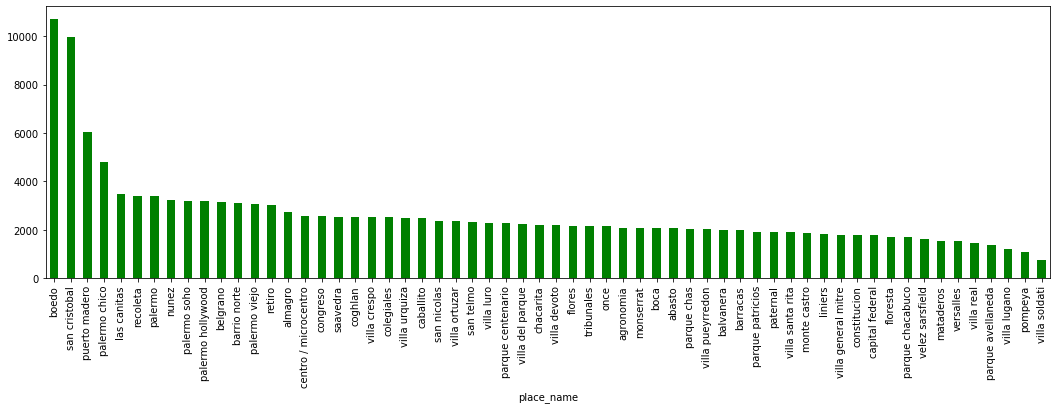

In [27]:
# Gráfico de las medias de precios por m2 por Barrio
plot_place_m2 = df2.groupby('place_name').describe()
plot_place_m2[('price_usd_per_m2', 'mean')].sort_values(ascending=False).plot.bar(figsize=(18,5), facecolor='g')

### Observando el grafico vemos algo raro ya que no sería esperado que el valor por m2 sea mayor en Boedo y San Cristobal que en Puerto Madero

In [30]:
# Análisis de la estadistica descriptiva de Boedo
out_boedo = df.loc[df['place_name'] == 'boedo']
out_boedo['price_usd_per_m2'].describe()

count       800.000000
mean      10697.513056
std       13188.768866
min         789.473684
25%        1675.405844
50%        7661.666667
75%       18322.849462
max      206333.333333
Name: price_usd_per_m2, dtype: float64

In [29]:
# y de San Cristobal
out_sc = df.loc[df['place_name'] == 'san cristobal']
out_sc['price_usd_per_m2'].describe()

count      454.000000
mean      9952.388570
std       9768.989436
min        662.790698
25%       1815.803794
50%       2716.831395
75%      21552.419643
max      26241.636364
Name: price_usd_per_m2, dtype: float64

Analizando estos dos barrios vemos que hay un salto importante en los valores de m2 a partir del percentilo 75%, pero no hay gran diferencia con el maximo por lo tanto podria no tratrse de outliers sino de una zona con gran variabilidad

In [ ]:
# Calculamos el desvio standar de cada Barrio
df_std_place = df2.groupby('place_name')['price_usd_per_m2'].std()
df_std_place

Repetimos lo hecho para provincia en donde establecimos los valores de corte para los outliers

In [ ]:
place_m2_pivot = df2.pivot_table(values='price_usd_per_m2',index='place_name',aggfunc= outlier_value_sup)
place_m2_pivot

In [ ]:
place_m2_pivot_new = place_m2_pivot.reset_index()
place_m2_pivot_new

In [ ]:
place_m2_index=df2[(df2['place_name']==place_m2_pivot_new.loc[0,'place_name']) &
                    (df['price_usd_per_m2']>place_m2_pivot_new.loc[0,'price_usd_per_m2'])].index.values
df.loc[place_m2_index]

No encontramos outliers por barrio de precio en dolares por m2

## Por precio en dolares

Repetimos el mismo filtro pero utilizando el precio en dolares ya que no sabemos como fue constriudo el data set, es decir si se utilizó el precio de m2 para determinar el precio final o si este fue cargado de forma independiente.

In [ ]:
# Calculamos la media de cada provincia 
df_media_state = df1.groupby('state_name')['price_aprox_usd'].mean()
df_media_state

In [ ]:
plot_place_precio = df.groupby('state_name').describe()
plot_place_precio[('price_aprox_usd', 'mean')].sort_values(ascending=False).plot.bar(figsize=(18,5), facecolor='b')

Nos llamó la atención el valor medio de catamarca muy por encima del resto de las provincias

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Para sacar la notacion cientifica
out_cat = df.loc[df['state_name'] == 'catamarca']
out_cat['price_aprox_usd'].describe()

Pasa lo mismo que en los casos anteriores donde a partir del percentilo 75% da un salto importante en precios

In [ ]:
# Calculamos el desvio standar de cada provincia
df_std_state = df1.groupby('state_name')['price_aprox_usd'].std()
df_std_state

In [ ]:
state_precio_pivot=df.pivot_table(values='price_aprox_usd',index='state_name',aggfunc= outlier_value_sup)
state_precio_pivot

In [ ]:
state_precio_pivot_new=state_precio_pivot.reset_index()
state_precio_pivot_new

In [ ]:
state_precio_index=df[(df['state_name']==state_precio_pivot_new.loc[0,'state_name']) &
                    (df['price_aprox_usd']>state_precio_pivot_new.loc[0,'price_aprox_usd'])].index.values
df.loc[state_precio_index]

In [ ]:
df.loc[state_precio_index, 'price_aprox_usd']

In [ ]:
df_new2 = df.drop(state_precio_index)

In [ ]:
xx5 = df_new3.groupby('state_name').describe()

In [ ]:
xx5[('price_aprox_usd', 'mean')].sort_values(ascending=False).plot.bar(figsize=(18,5), facecolor='b')

Vamos a sacar outliers a nivel Barrios (place_name) unicamente en Capital Federal 

In [ ]:
df3 = df.loc[(df['state_name'] == 'Capital Federal')]
df3['place_name'].value_counts()

In [ ]:
# Queremos sacar los place_names con una frecuencia menos a x casos
df3 = df3.groupby('place_name').filter(lambda x: len(x) > 10)
df3.shape

In [ ]:
# Calculamos la media de cada Barrio 
df_media_place = df3.groupby('place_name')['price_aprox_usd'].mean()
df_media_place

In [ ]:
xx6 = df3.groupby('place_name').describe()

In [ ]:
xx6[('price_aprox_usd', 'mean')].sort_values(ascending=False).plot.bar(figsize=(18,5), facecolor='b')

In [ ]:
# Calculamos el desvio standar de cada Barrio
df_std_place = df3.groupby('place_name')['price_aprox_usd'].std()
df_std_place

In [ ]:
out_vs = df3.loc[df['place_name'] == 'Villa Soldati']
out_vs['price_aprox_usd'].describe()

In [ ]:
aux_pivot4=df3.pivot_table(values='price_aprox_usd',index='place_name',aggfunc= outlier_value_sup)
aux_pivot4

In [ ]:
aux_pivot_new4=aux_pivot4.reset_index()
aux_pivot_new4

In [ ]:
aux_index_values4=df[(df['place_name']==aux_pivot_new4.loc[0,'place_name']) &
                    (df['price_aprox_usd']>aux_pivot_new4.loc[0,'price_aprox_usd'])].index.values
df.loc[aux_index_values4]

In [ ]:
df.loc[aux_index_values4, 'price_aprox_usd']

In [ ]:
df_new4 = df.drop(aux_index_values4)

In [ ]:
df_new5 = df3.drop(aux_index_values4)

In [ ]:
xx7 = df_new5.groupby('place_name').describe()

In [ ]:
xx6[('price_aprox_usd', 'mean')].sort_values(ascending=False).plot.bar(figsize=(18,5), facecolor='b')